In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA

In [30]:
def inhomogenous_poisson_spikes(rates, dt):
    """
    generate spikes from `n` (number of rows in rates) time-continuous point processes with time-dependent rates `rate_i` (ith row of rates)
    """
    #start with empty array
    spikes = []
    for i in np.arange(rates.shape[0]):
        time = 0
        rate_i = rates[i]
        time_max = len(rate_i)*dt
        rate_max = rate_i.max()
        while time < time_max:
            time += np.random.exponential()/rate_max
            if time < time_max:
                if np.random.random() < rate_i[int(time/dt)]/rate_max:
                    spikes.append([i,time])
        
    return np.array(spikes)

# Example: spikes with 2D latent model
Here, we construct spikes for $N$ neurons from time-dependent rates $\nu_i(t)$ that are linear combinations from a latend model with $z(t)$

Specifically, we choose 
$$
   z_1(t) = sin(2\pi t) + 1\\
   z_2(t) = sin(2\pi t + \pi/2) + 1
$$

(2, 5000)


Text(0.5, 1.0, 'Latent space')

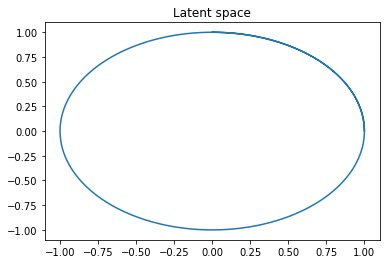

In [38]:
def z(t, omega):
    z_1 = np.sin(0.5*2*np.pi*omega*t)
    z_2 = np.cos(0.5*2*np.pi*omega*t)
    return np.vstack((z_1,z_2))

dt=0.001
T=5
ts=np.arange(0,T,dt)
zs=z(ts, 0.5)
print(zs.shape)
plt.plot(zs[0,:],zs[1,:]) 
plt.title("Latent space")

Then, we generate neural firing rates as linear combinations of the latent variables

$$
  \nu_i (t) = c_1*z_1(t) + c_2*z_2(t) + offset
$$

In [51]:
N = 32
mean_rate = 20
offset = mean_rate + 2*np.random.randn(N)
#offset = mean_rate
coefficients = 2*np.random.randn(N,2)
#coefficients = np.ones((N,2))
print(coefficients.shape)
drate_t = np.matmul(coefficients,zs)
print(drate_t.shape)
rate_t = offset[:, np.newaxis] + drate_t
#plt.plot(ts, rate_t.T);
#plt.plot(np.mean(rates, axis=0));
#print(rate_t[1].shape)

(32, 2)
(32, 5000)


[7.18300925e-01 2.41553396e-01 4.01456788e-02 2.03006891e-30
 9.56973492e-31 5.91700016e-31 3.28217800e-31 3.25565392e-33
 3.25565392e-33 3.25565392e-33 3.25565392e-33 3.25565392e-33
 3.25565392e-33 3.25565392e-33 3.25565392e-33 3.25565392e-33
 3.25565392e-33 3.25565392e-33 3.25565392e-33 3.25565392e-33
 3.25565392e-33 3.25565392e-33 3.25565392e-33 3.25565392e-33
 3.25565392e-33 3.25565392e-33 3.25565392e-33 3.25565392e-33
 3.25565392e-33 3.25565392e-33 3.25565392e-33 1.33523697e-33]
[8.97933296e+02 5.20711821e+02 2.12280580e+02 1.50954566e-12
 1.03643201e-12 8.14970058e-13 6.06976571e-13 6.04519033e-14
 6.04519033e-14 6.04519033e-14 6.04519033e-14 6.04519033e-14
 6.04519033e-14 6.04519033e-14 6.04519033e-14 6.04519033e-14
 6.04519033e-14 6.04519033e-14 6.04519033e-14 6.04519033e-14
 6.04519033e-14 6.04519033e-14 6.04519033e-14 6.04519033e-14
 6.04519033e-14 6.04519033e-14 6.04519033e-14 6.04519033e-14
 6.04519033e-14 6.04519033e-14 6.04519033e-14 3.87141775e-14]


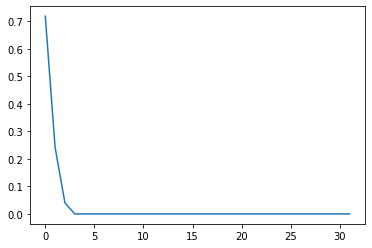

In [49]:
pca = PCA()
pca.fit(rate_t)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
plt.plot(pca.explained_variance_ratio_)

To get a bit more realistic, let's generate actual spikes as an inhomogeneous poisson process

In [32]:
spikes = inhomogenous_poisson_spikes(rate_t, dt)
print(spikes[:,1])

[0.17474644 0.18107398 0.19041149 ... 4.91472833 4.92426559 4.93969068]


Follow analysis of https://www.nature.com/articles/s41593-019-0555-4

Bin spikes in windows of size 30ms

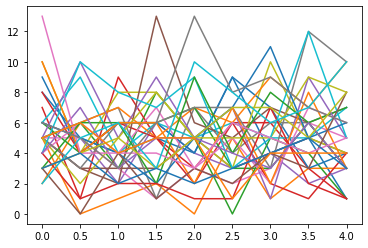

In [33]:
delta_t = 0.5 # 0.03
sd_t = 0.5    #0.05
counts, _, time = np.histogram2d(spikes[:,0], spikes[:,1],bins=[np.arange(N+1),np.arange(0,T,delta_t)])
plt.plot(time[:-1], counts.T);

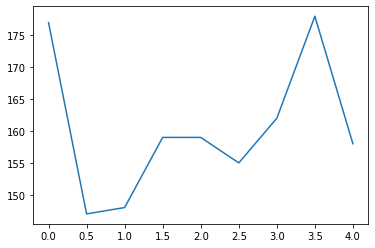

In [34]:
plt.plot(time[:-1], np.sum(counts.T, axis=1));

Now make square root transform

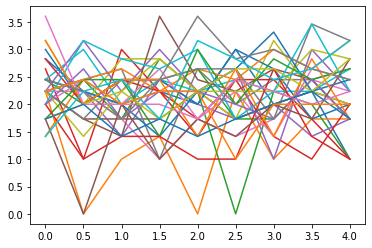

In [35]:
sqcounts = np.sqrt(counts)
plt.plot(time[:-1], sqcounts.T);

and apply Gaussian filter (with s.d. of 50ms)

(32, 9)


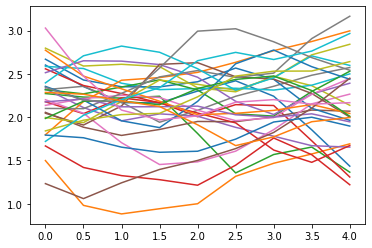

In [36]:
from scipy.ndimage import gaussian_filter1d
print(sqcounts.shape)
sd=sd_t/delta_t
signal = gaussian_filter1d(sqcounts, sigma=sd, axis=1)
plt.plot(time[:-1], signal.T);

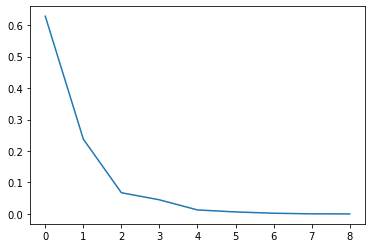

In [37]:
pca = PCA()
# print(signal.shape)
pca.fit(signal)
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)
plt.plot(pca.explained_variance_ratio_)